In [1]:
from pathlib import Path
import pandas as pd
import sys
import os
import tensorflow as tf
from tensorflow import keras
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from functools import reduce

In [2]:
from data_access.load_file import load_table
from data_processing.functions import time_for_phase
from data_preparation import compute_work_item_times
from data_processing import features

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

Load data

In [4]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)

Add features and binarize (every work item with a duration above 148 (->upper whisker) will be marked as an outlier)

In [5]:
times = time_for_phase(data)
total_times = compute_work_item_times(data)
work_times = features.work_times(times, time_col="duration_in_days")
work_frequency = features.work_times(times)
process_length = features.process_length(times)
is_open = features.is_open(data)
is_outlier = features.is_outlier(total_times, time_col="duration_in_days")

(0, 200)

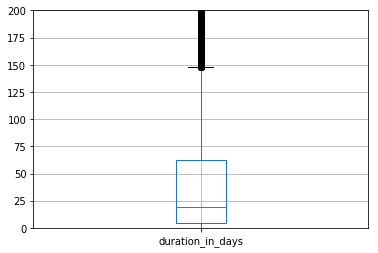

In [6]:
total_times.boxplot(column="duration_in_days")
plt.ylim((0,200))

We set all items with time above the upper whisker to be an outlier. Now we merge everythin into one df

In [7]:
final = reduce(lambda x, y: pd.merge(x, y, on="work_item", how="inner"), [work_times, work_frequency, process_length, is_open, is_outlier])

In [8]:
final.drop_duplicates("work_item", inplace=True)
final.set_index("work_item", inplace=True)

Encode columns to get binary data

In [9]:
cols_to_encode = ["domain", "work_priority", "work_type", "platform", "components"]
encode = data[["work_item", *cols_to_encode]].drop_duplicates("work_item")
encoded = pd.get_dummies(encode, columns=cols_to_encode)

In [10]:
final = pd.merge(final, encoded, left_index=True, right_on="work_item").set_index("work_item")

In [11]:
final.head()

,Accept,Analyze,Build,Clarify,Deploy,Design,End,Package,Test,Accept_freq,...,components_CO_00173/CO_00174,components_CO_00173/CO_00175,components_CO_00174,components_CO_00175,components_CO_00176,components_CO_00177,components_CO_00177/CO_00027,components_CO_00177/CO_00108,components_CO_00177/CO_00139,components_CO_00177/CO_00176
work_item,,,,,,,,,,,,,,,,,,,,,
WI_000001,1.10,4.82,5.83,0.0,7.02,0.17,0.0,3.91,2.03,1,...,0,0,0,0,0,0,0,0,0,0
WI_000002,0.00,11.78,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0,...,0,0,0,0,0,0,0,0,0,0
WI_000003,0.00,44.89,0.00,0.0,0.00,6.88,0.0,0.00,3.08,0,...,0,0,0,0,0,0,0,0,0,0
WI_000004,2.05,11.80,0.00,0.0,11.89,0.00,0.0,0.00,0.00,1,...,0,0,0,0,0,0,0,0,0,0
WI_000005,0.05,25.69,0.98,0.0,6.10,0.03,0.0,0.00,0.00,1,...,0,0,0,0,0,0,0,0,0,0


Split into training and test data

In [12]:
x_data = final[list(set(final.columns) - set(["is_outlier", "End_freq"]))]
y_data = pd.DataFrame(final["is_outlier"])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [13]:
print("The training set has the classes: ", end="\n")
print(y_train.is_outlier.value_counts())
print("---------------------------------")
print("The test set has the classes: ", end="\n")
print(y_test.is_outlier.value_counts())

The training set has the classes: 
0    7049
1     698
Name: is_outlier, dtype: int64
---------------------------------
The test set has the classes: 
0    3459
1     358
Name: is_outlier, dtype: int64


Use Logistic Regression to predict classification of outliers

In [14]:
logres = LogisticRegression()

In [15]:
fit = logres.fit(x_train, y_train)

In [16]:
scores = cross_val_score(logres, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.01)


In [17]:
score = fit.score(x_test, y_test)
print("The mean accuracy of the Model is %0.2f"%score)

The mean accuracy of the Model is 0.97


In [18]:
# sorted(list(zip(x_train.columns, fit.coef_[0])), key=(lambda x: x[1]), reverse=True)

The frequencies of processes have a high impact on the model for positive (class 1) classification. Which could lead to the assumption that outliers run through phases multiple times and because of that they need a lot of more time. Is_open is the main coefficient for classifying negative (class 0) labels. So the model is more likely to not mark opened workitems as outliers

Predict probabilities for training and test data

In [19]:
train_predictions = pd.DataFrame(x_train.index)
train_predictions["predictions"] = fit.predict_proba(x_train)[:, 1]
test_predictions = pd.DataFrame(x_test.index)
test_predictions["predictions"] = fit.predict_proba(x_test)[:, 1]

Text(0.5, 0, 'is_outlier')

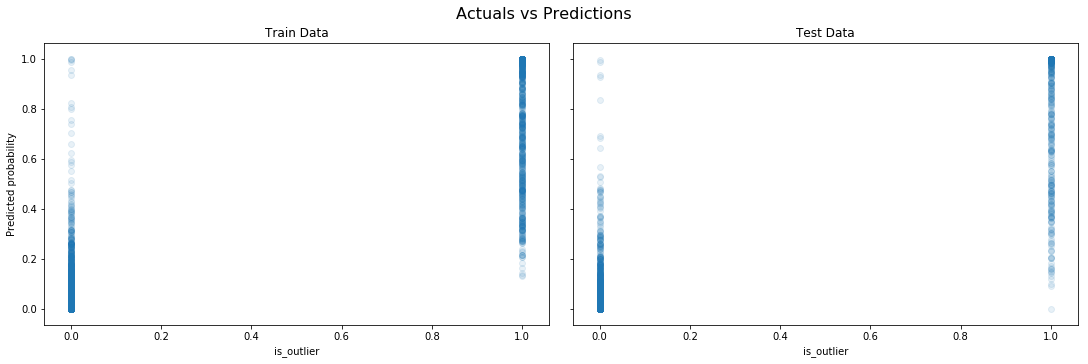

In [20]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
fig.suptitle('Actuals vs Predictions', fontsize=16)
axs[0].scatter(x=y_train.is_outlier, y=train_predictions.predictions, alpha=0.1)
axs[0].set_title('Train Data')
axs[0].set_xlabel('is_outlier')
axs[0].set_ylabel('Predicted probability')
axs[1].scatter(x=y_test.is_outlier, y=test_predictions.predictions, alpha=0.1)
axs[1].set_title('Test Data')
axs[1].set_xlabel('is_outlier')

Seems like probability predictions doesn't work very accurate. Let's see the prediction results in relation to the time

In [21]:
predict_df = final[list(set(final.columns) - set(["is_outlier", "End_freq"]))]
submit_predictions = pd.DataFrame(predict_df.index)
submit_predictions["predictions"] = fit.predict_proba(predict_df)[:, 1]

In [22]:
durout = pd.merge(total_times[["work_item", "duration_in_days"]], pd.DataFrame(final["is_outlier"]), how="inner", left_on="work_item", right_index=True)
plot_df = pd.merge(durout, submit_predictions, how="left")

In [23]:
outliers = plot_df[plot_df["is_outlier"]==1]
inliers = plot_df[plot_df["is_outlier"]==0]

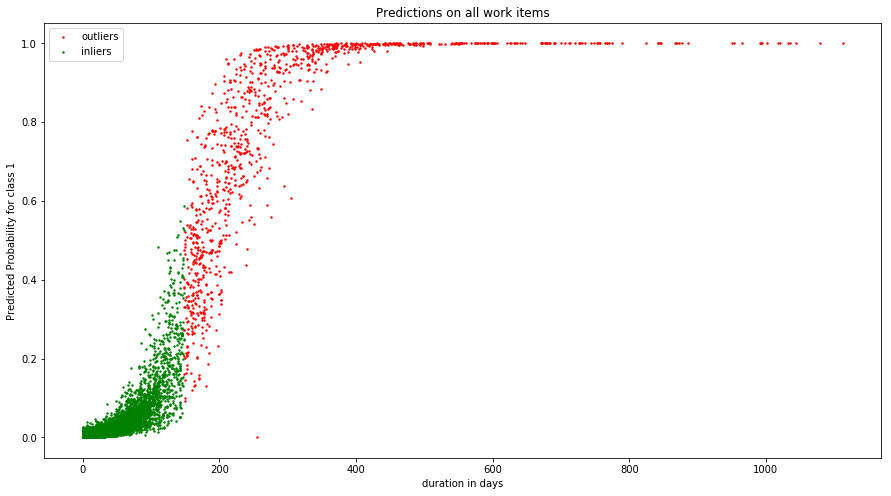

In [24]:
plt.figure(figsize=(15,8))
plt.scatter(x=outliers["duration_in_days"], y=outliers["predictions"], s=2, color='red', label="outliers")
plt.scatter(x=inliers["duration_in_days"], y=inliers["predictions"], s=2, color='green', label="inliers")
plt.legend()
plt.ylabel("Predicted Probability for class 1")
plt.xlabel("duration in days")
plt.title("Predictions on all work items")
plt.show()

This looks good. With increasing duration, the probability of being an outlier increases too. This is could be a good feature for identifying outliers.

Let's check some other classifiers

In [25]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

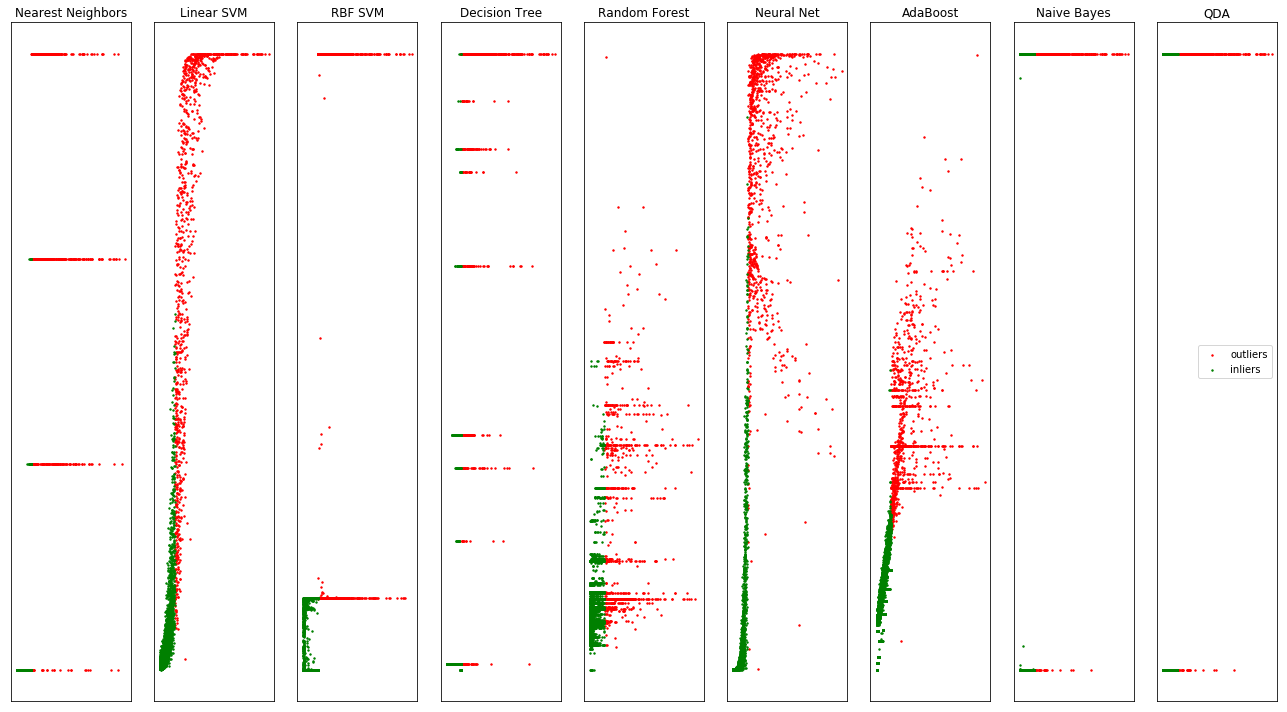

In [26]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

figure = plt.figure(figsize=(20, 10))
i = 1
# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    fit = clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    
    predict_df = final[list(set(final.columns) - set(["is_outlier", "End_freq"]))]
    submit_predictions = pd.DataFrame(predict_df.index)
    submit_predictions["predictions"] = fit.predict_proba(predict_df)[:, 1]
    durout = pd.merge(total_times[["work_item", "duration_in_days"]], pd.DataFrame(final["is_outlier"]),
                      how="inner", left_on="work_item", right_index=True)
    plot_df = pd.merge(durout, submit_predictions, how="left")
    outliers = plot_df[plot_df["is_outlier"]==1]
    inliers = plot_df[plot_df["is_outlier"]==0]
    
    ax.scatter(x=outliers["duration_in_days"], y=outliers["predictions"], s=2, color='red', label="outliers")
    ax.scatter(x=inliers["duration_in_days"], y=inliers["predictions"], s=2, color='green', label="inliers")
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    i += 1

plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def plot_predictions(model):
    predict_df = final[list(set(final.columns) - set(["is_outlier", "End_freq"]))]
    submit_predictions = pd.DataFrame(predict_df.index)
    submit_predictions["predictions"] = model.predict(predict_df)[:, 1]
    durout = pd.merge(total_times[["work_item", "duration_in_days"]], pd.DataFrame(final["is_outlier"]),
                        how="inner", left_on="work_item", right_index=True)
    plot_df = pd.merge(durout, submit_predictions, how="left")
    outliers = plot_df[plot_df["is_outlier"]==1]
    inliers = plot_df[plot_df["is_outlier"]==0]

    plt.scatter(x=outliers["duration_in_days"], y=outliers["predictions"], s=2, color='red', label="outliers")
    plt.scatter(x=inliers["duration_in_days"], y=inliers["predictions"], s=2, color='green', label="inliers")
    plt.tight_layout()
    plt.show()
    return submit_predictions

The neural net works good too, so we should try an other approach with a more specified neural net

In [28]:
print("Train data shape = {}".format(x_train.shape))
print("Test data shape = {}".format(x_test.shape))

Train data shape = (7747, 372)
Test data shape = (3817, 372)


In [34]:
model = keras.Sequential([
        keras.layers.Dense(372, activation=tf.nn.relu),
        keras.layers.Dense(120, activation=tf.nn.relu),
        keras.layers.Dense(50, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

In [35]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.fit(x_train.values, y_train.values, epochs=20, verbose=False)

In [37]:
test_loss, test_acc = model.evaluate(x_test.values, y_test.values)
print("The test accuracy is %0.2f"%test_acc)

3817/3817 [==============================] - 0s 62us/sample - loss: 0.0395 - accuracy: 0.9908
The test accuracy is 0.99


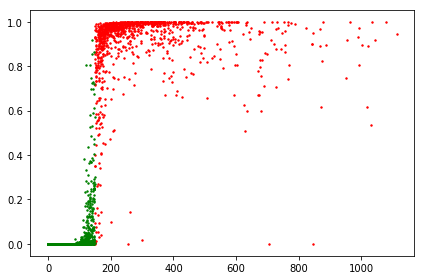

In [38]:
s = plot_predictions(model)

In [39]:
s.to_csv("../data/outlier_prediction.csv", index=False)